# Time-series Project:<br>Air Passengers

## Loading Python libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
import joblib

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('ggplot')

## Loading Data

In [3]:
df = pd.read_csv('AirPassengers.csv', 
                 index_col=0, #set index as date column
                 parse_dates=True) #parse date into datetime dtype

---

# Box-Jenkins method

## 1. Model Identification

### 1.1. Exploring Data

In [4]:
df.shape

(144, 1)

In [5]:
df.head(3)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


In [6]:
df.tail(3)

,#Passengers
Month,
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [9]:
# Dataset timeframe
print('Dataset spans', df.index.max() - df.index.min())

Dataset spans 4352 days 00:00:00


In [10]:
# Rename column and index
df.columns = ['air_passengers']
df.index.names = ['date']

In [11]:
# Set time-series frequency by offset alias 
df.index.freq = 'MS' #month start frequency

In [12]:
df.head(3)

,air_passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132


**Documentation:**
* The data set is comprised of monthly air passenger figures (1000's) from Jan 1949 until Dec 1960 (144 months = 144 observations) without missing or zero values

### 1.2. Stationarity

#### 1.2.1. Plotting time series

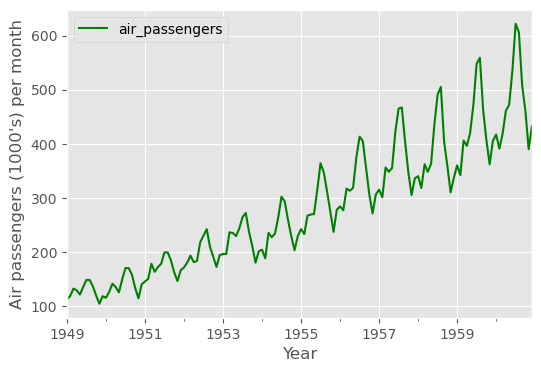

In [13]:
# Plot data
fig, ax = plt.subplots(figsize=(6,4))
df.plot(ax=ax, color='green')
plt.xlabel('Year')
plt.ylabel("Air passengers (1000's) per month");

**Documentation:**

The data plot shows 
* an upward trend (values increase with time)
* a seasonal pattern (predictable patterns that repeat regularly)
* a multiplicative seasonality (amplitude of the seasonal oscillations gets larger as the data trends up)
* a constant autocorrelation (value related to its neighbors stays the same)

**Conclusion: The data appears to be non-stationary with a multiplicative seasonality**

#### 1.2.2. Augmented Dicky-Fuller test

A statistical test to identify whether a time series is non-stationary is the augmented Dicky-Fuller test.

**Null hypothesis H$_{0}$: Time series is not stationary due to trend.**

In [14]:
results = adfuller(df['air_passengers']) #results object is a tuple

# Print Dicky-Fuller test results
print(f'Dicky-Fuller test results:{results}\n') #0th element: test statistic, 1st element: pval

# Print test statistic
print(f'test statistic:{results[0]}\n')

# Print p-value
print(f'p-value:{np.round(results[1], 3)}\n')

# Print critical values
print(f'critical values:{results[4]}') 

Dicky-Fuller test results:(0.8153688792060543, 0.9918802434376411, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)

test statistic:0.8153688792060543

p-value:0.992

critical values:{'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


**Documentation:**
* pval > 0.05: Null hypothesis is confirmed

**Conclusion: Time series data is not stationary**

### 1.3. Seasonality

**Seasonal decomposition**

Any time series can be thought of as being **made of 3 parts: The trend, the seasonal component, and the residual.** The full time series is these three parts added together.

**Identifying seasonal period using ACF**

In order to decompose the data, use the ACF plot to first identify the seasonal period. The ACF plot will be clearer after subtracting the rolling mean. The ACF shows a periodic correlation pattern. To find the seasonal period identify the peak in the ACF plot which has a lag greater than one

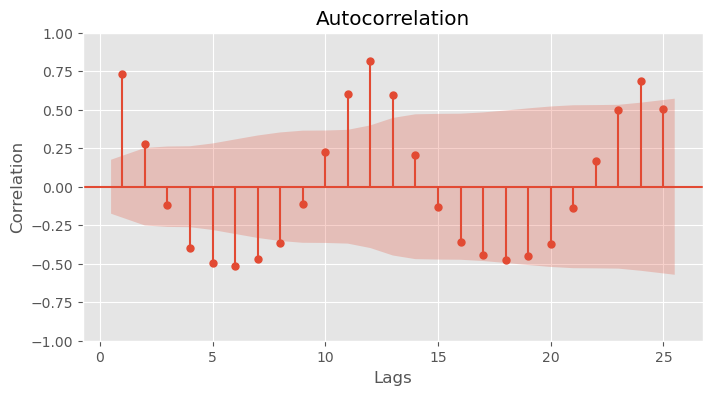

In [15]:
# Subtract rolling average over N steps

N = 20 #value of any size bigger than the period

df_rm = df - df.rolling(N).mean()

# Drop NaN values
df_rm = df_rm.dropna()

# Create figure and subplots
fig, ax = plt.subplots(figsize=(8,4))

# Plot the ACF
plot_acf(df_rm['air_passengers'], lags=25, zero=False, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Correlation'); 

**Documentation:**
* Time period of the seasonal component of this data: 12 time steps per cycle (S)

**Seasonal decomposition**

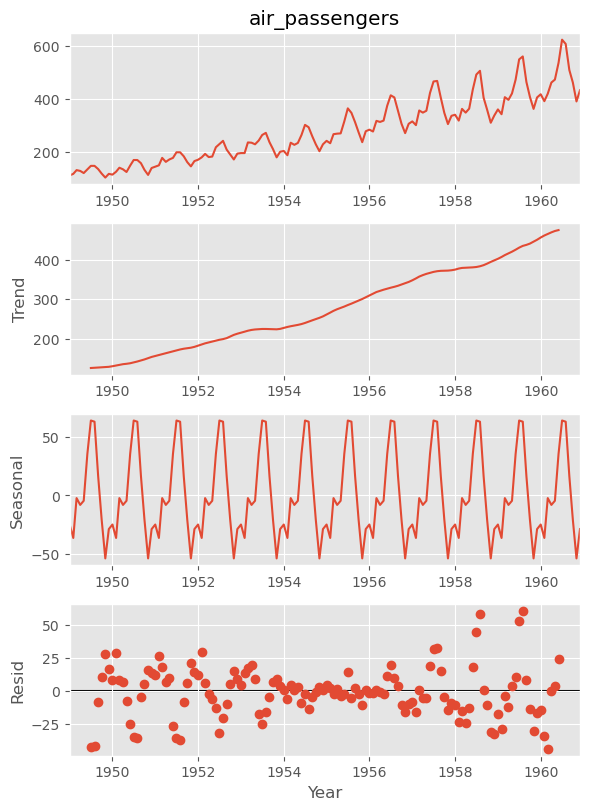

In [16]:
# Decompose seasonal data

S = 12 #seasonal period
decomp_results = seasonal_decompose(df['air_passengers'], period=S) #period: number of data points in each repeated cycle

# Plot decomposed data
plt.rcParams['figure.figsize'] = (6,8)
decomp_results.plot()
plt.xlabel('Year');

**Documentation:**
* After extracting the seasonal cycle the trend can be seen much more clearly

### 1.4. SARIMA models

A SARIMA or seasonal ARIMA model is the tool of choice for seasonal time series.

**SARIMA(p,d,q)(P,D,Q)S**

Non-seasonal orders:
* p: autoregressive order
* d: differencing order
* q: moving average order

Seasonal orders:
* P: seasonal autoregressive order
* D: seasonal differencing order
* Q: seasonal moving average order
* S: number of time steps per cycle

#### 1.4.1. Differencing for SARIMA models

* If the time series shows a **trend** perform the **normal non-seasonal difference (d)**

* If there is a **strong seasonal cycle**, **also** perform the **seasonal difference (D)**

* **Additive vs multiplicative seasonality**: Whenever the seasonality is **additive**, taking the **difference** should be **sufficient**. Additive seasonality is where the seasonal pattern just adds or subtracts a little from the trend. When the seasonality is **multiplicative**, the SARIMA model can't fit the data without **extra transformations**. **If the seasonality is multiplicative the amplitude of the seasonal oscillations will get larger as the data trends up** or smaller as it trends down. To deal with this apply **log transformation before modeling the data**

**Multiplicative to additive seasonality**

In [17]:
# Apply log transformation to make multiplicative seasonality additive
df_log = np.log(df)

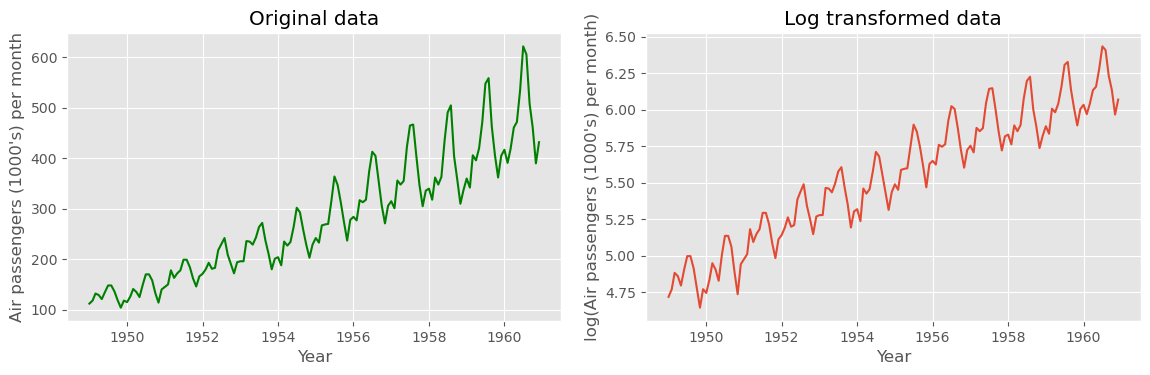

In [18]:
# Plot data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.tight_layout(pad=3)

ax1.plot(df.index, df['air_passengers'], color='green') #original data
ax2.plot(df.index, df_log['air_passengers']) #logarithmized data

ax1.set_xlabel('Year')
ax1.set_ylabel("Air passengers (1000's) per month")
ax1.set_title('Original data')

ax2.set_xlabel('Year')
ax2.set_ylabel("log(Air passengers (1000's) per month)")
ax2.set_title('Log transformed data');

**Perform non-seasonal and seasonal differencing on additive seasonality**

In [19]:
# Calculate non-seasonal and seasonal differences and drop NaNs
df_diff = df_log.diff().diff(12).dropna() #seasonal period S: 12

ADF Statistic: -4.4433249418311105
p-value: 0.0002485912311384173


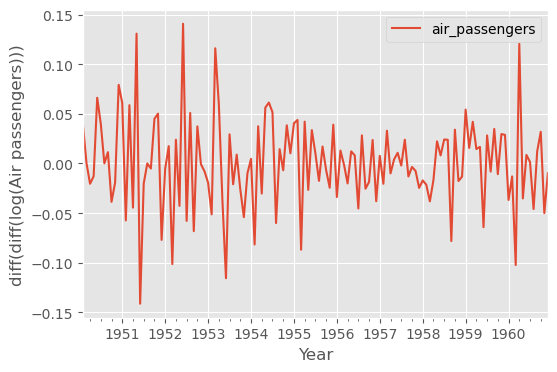

In [20]:
# Run ADF test on differenced time series
results = adfuller(df_diff['air_passengers'])

# Plot differenced time series
fig, ax = plt.subplots(figsize=(6,4))
df_diff.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('diff(diff(log(Air passengers)))');

# Print test statistic and p-value
print('ADF Statistic:', results[0])
print('p-value:', results[1])

**Documentation:**
* Taking a single non-seasonal and seasonal difference each made the data stationary

#### 1.4.2. Finding non-seasonal model orders p and q

To find the **non-seasonal orders**, plot the ACF and the PACF of the differenced time series

(P)ACF: (partial) autocorrelation function

Plot ACF and PACF: Select best model order fit

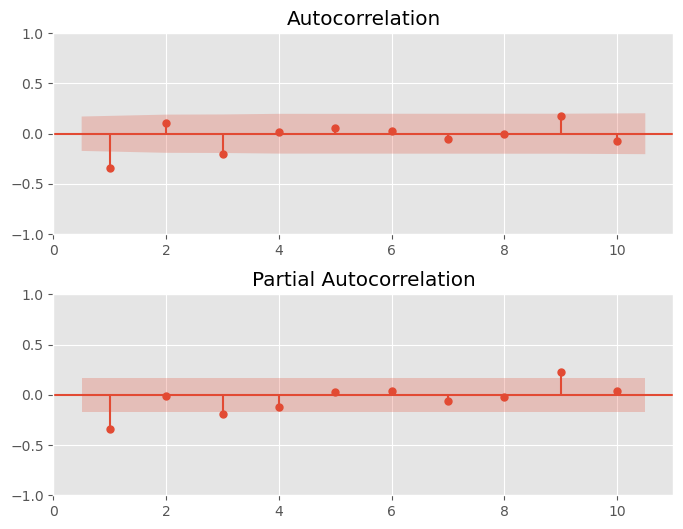

In [21]:
# Plot ACF and PACF of differenced data
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6))

# Make ACF plot
plot_acf(df_diff, lags=10, zero=False, ax=ax1) #zero: zero-lag

# Make PACF plot
plot_pacf(df_diff, lags=10, zero=False, method='ywm', ax=ax2)
plt.subplots_adjust(hspace=0.3);

#### 1.4.3. Finding seasonal model orders P and Q

To find the **seasonal orders** we plot the ACF and PACF of the differenced time series at **multiple seasonal steps**. Then we can use the same table of ACF and PACF rules to work out the seasonal order.

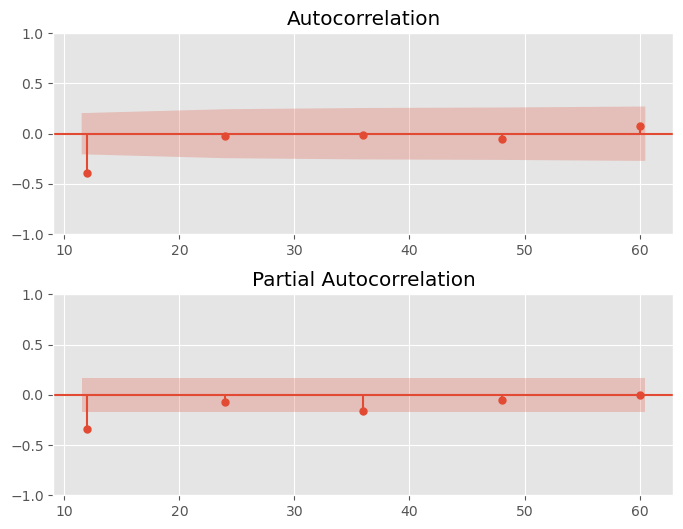

In [22]:
# Make list of lags
lags = [12, 24, 36, 48, 60]

# Create figure
fig, (ax1, ax2) = plt. subplots(2,1, figsize=(8,6))

# Make ACF plot
plot_acf(df_diff, lags=lags, ax=ax1) #zero: zero-lag

# Make PACF plot
plot_pacf(df_diff, lags=lags, method='ywm', ax=ax2)
plt.subplots_adjust(hspace=0.3);

**Documentation:**
* Difficult to select model orders as plots don't show the usual patterns of AR, MA or ARMA models 
* Select SARIMAX(0,1,1)(0,1,1, 12) model

#### 1.4.4. Fitting SARIMA model

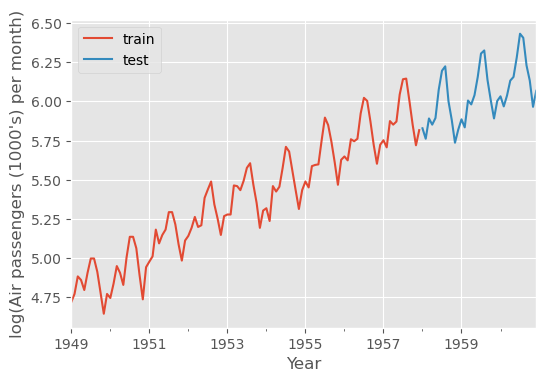

In [23]:
# Split data into train (~75%) and test (~25%) set
df_train = df_log.loc[:'1957']
df_test = df_log.loc['1958':]

# Visualize split
fig, ax = plt.subplots(figsize=(6,4))

df_train.plot(ax=ax)
df_test.plot(ax=ax)

plt.xlabel('Year')
plt.ylabel("log(Air passengers (1000's) per month)")
plt.legend(['train','test']);

In [24]:
# Create a SARIMA model
model = SARIMAX(df_train, order=(0,1,1), seasonal_order=(0,1,1,12))

# Fit the model
results = model.fit()

#### 1.4.5. Model diagnostics

**Summary statistics**

In [25]:
# Print the results summary
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     air_passengers   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 175.293
Date:                            Sat, 14 Jan 2023   AIC                           -344.586
Time:                                    17:27:11   BIC                           -336.924
Sample:                                01-01-1949   HQIC                          -341.490
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3858      0.098     -3.927      0.000      -0.578      -0.193
ma.S.L12      -0.5886      0.113   

**Interpretation**

Ljung-Box test: 
* H$_{0}$: There are no correlations in the residuals
* If Prob(Q) p-value < 0.05: There are correlations in the residuals 

Jarque-Bera test: 
* H$_{0}$: The residuals are normally distributed
* If Prob(JB) p-value < 0.05: The residuals are not Gaussian normally distributed

**Plot diagnostics**

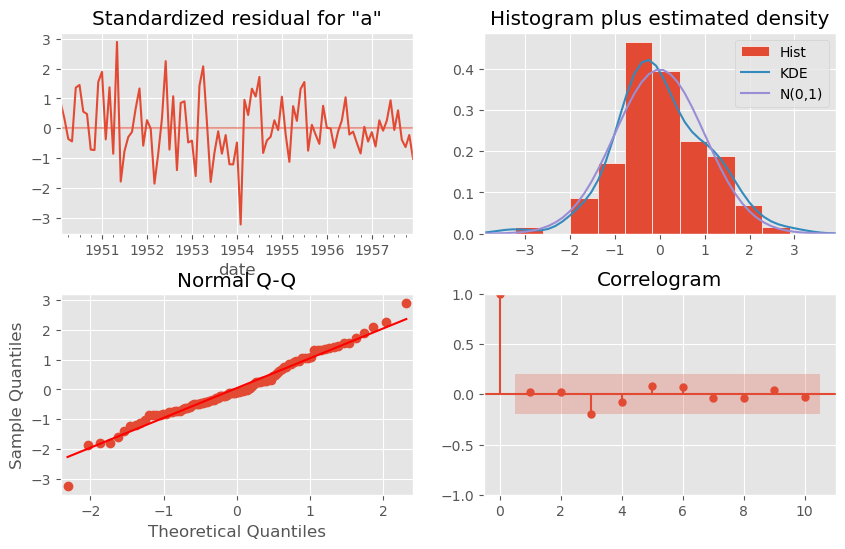

In [26]:
# Create 4 diagnostics plots
results.plot_diagnostics(figsize=(10,6))
plt.subplots_adjust(hspace=0.3);

**Interpretation**
* Standardized residual: There are no obvious patterns in the residuals
* Histogram plus KDE estimate: The KDE kurve should be very similar to the normal distribution
* Normal Q-Q: Most of the data points should lie on the straight line
* Correlogram: 95% of correlations for lag greater than zero should not be significant 

---

## 2. Model Estimation

### 2.1. Automation: Finding optimal model orders

Use the auto_arima function from the pmdarima package to loop over model orders to find the best ones

In [27]:
# Auto-ARIMA function using default parameters
pm_model = pm.auto_arima(df_train)

In [28]:
# Set search parameters as required
pm_model = pm.auto_arima(df_train,  # data
                        d=1,        # non-seasonal difference order
                        start_p=0,  # initial guess for p
                        start_q=0,  # initial guess for q
                        max_p=2,    # max value for p to test
                        max_q=2,    # max value for q to test
                        seasonal=True,  # is the time series seasonal
                        m=12,        # seasonal period
                        D=1,        # seasonal difference order
                        start_P=0,  # initial guess for P
                        start_Q=0,  # initial guess for Q
                        max_P=2,    # max value for P to test
                        max_Q=2,    # max value for Q to test
                        information_criterion='aic',  #used to select best model
                        trace=True,                   # print results whilst training
                        error_action='ignore',        # ignore orders that don't work
                        stepwise=True)                # apply intelligent order search                        

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-307.418, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-336.580, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-344.586, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-317.948, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-342.742, Time=0.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-342.762, Time=0.76 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-338.356, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-340.703, Time=0.77 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-335.022, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-343.299, Time=0.51 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-342.852, Time=0.31 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-343.512, Time=0.27 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-340.587, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-342.589, Time=0.60 sec

Best model:  ARIMA

---

## 3. Model diagnostics 

### 3.1. Summary statistics

In [29]:
# Print results summary
print(pm_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 175.293
Date:                            Sat, 14 Jan 2023   AIC                           -344.586
Time:                                    17:27:21   BIC                           -336.924
Sample:                                01-01-1949   HQIC                          -341.490
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3858      0.098     -3.927      0.000      -0.578      -0.193
ma.S.L12      -0.5886      0.113   

**Interpretation**

Ljung-Box test: 
* H$_{0}$: There are no correlations in the residuals
* If Prob(Q) p-value < 0.05: There are correlations in the residuals 

Jarque-Bera test: 
* H$_{0}$: The residuals are normally distributed
* If Prob(JB) p-value < 0.05: The residuals are not Gaussian normally distributed

### 3.2. Plot diagnostics

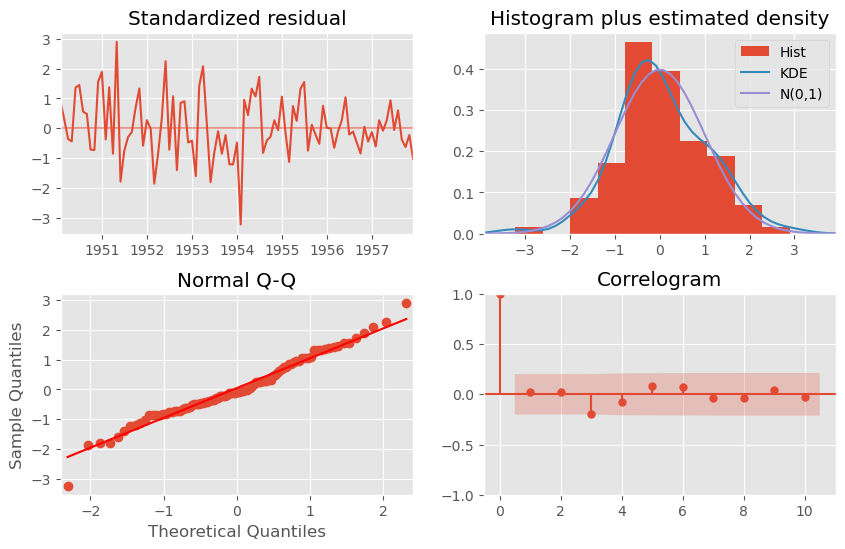

In [30]:
# Create 4 diagnostics plots
pm_model.plot_diagnostics(figsize=(10,6))
plt.subplots_adjust(hspace=0.3);

**Interpretation**
* Standardized residual: There are no obvious patterns in the residuals
* Histogram plus KDE estimate: The KDE kurve should be very similar to the normal distribution
* Normal Q-Q: Most of the data points should lie on the straight line
* Correlogram: 95% of correlations for lag greater than zero should not be significant 

### 3.3. Saving model object

In [31]:
# Select a filepath
filepath = 'airpass_model.pkl'

# Save model to filepath
joblib.dump(pm_model, filepath)

# Load model back in 
airpass_model = joblib.load(filepath)

---

## 4. SARIMA forecasting

### 4.1. One-step-ahead predictions

Evaluate how good the model is at predicting just one value ahead by performing **in-sample predictions**. The mean prediction is marked with a green line while the uncertainty range is shaded. The uncertainty is due to the random shock terms which can't be predicted

**Generating one-step-ahead-predictions**

In [32]:
# Create a SARIMA model
model = SARIMAX(df, order=(0,1,1), seasonal_order=(0,1,1,12))

# Fit the model
results = model.fit()

# Generate predictions
one_step_forecast = results.get_prediction(start=-36)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower air_passengers']
upper_limits = confidence_intervals.loc[:,'upper air_passengers']

# Print best estimate predictions and confidence intervals
print(mean_forecast[:3],'\n')
print(confidence_intervals[:3])

date
1958-01-01    347.151705
1958-02-01    328.930243
1958-03-01    374.707764
Freq: MS, Name: predicted_mean, dtype: float64 

            lower air_passengers  upper air_passengers
date                                                  
1958-01-01            324.343278            369.960132
1958-02-01            306.121816            351.738670
1958-03-01            351.899337            397.516191


**Plotting one-step-ahead predictions**

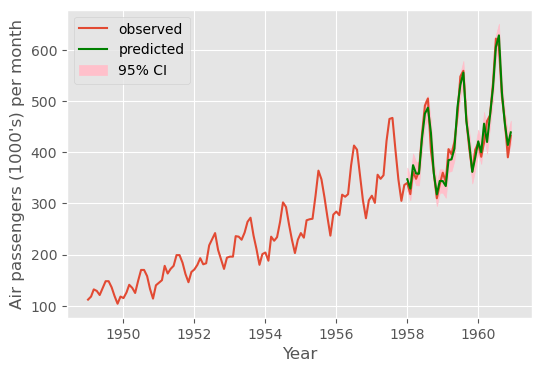

In [33]:
plt.figure(figsize=(6,4))

# Plot air passenger data
plt.plot(df.index, df, label='observed')

# Plot mean predictions as line
plt.plot(mean_forecast.index, mean_forecast, color='g', label='predicted')

# Shade area between confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, label='95% CI', color='pink')

# Set labels, etc.
plt.xlabel('Year')
plt.ylabel("Air passengers (1000's) per month")
plt.legend();

### 4.2. Forecasting out-of-sample

**Forecasting air passenger figures for 60 months post training set**

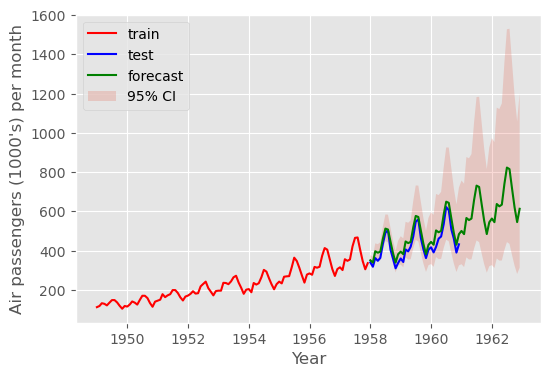

In [34]:
# Split data into train (~75%) and test (~25%) set
df_train = df_log.loc[:'1957']
df_test = df_log.loc['1958':]

# Create a SARIMA model
model = SARIMAX(df_train, order=(0,1,1), seasonal_order=(0,1,1,12))

# Fit the model
results = model.fit()

# Make forecast of next 60 values
forecast = results.get_forecast(steps=60)

# Forecast mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of forecasts
conf_int = forecast.conf_int()

# Inverse log results
mean_forecast = np.exp(mean_forecast)
conf_int = np.exp(conf_int)

# Extract the forecast dates
dates = mean_forecast.index

plt.figure(figsize=(6,4))

# Plot air passenger numbers
plt.plot(df_train.index, df.loc[:'1957'], color='r', label='train')
plt.plot(df_test.index, df.loc['1958':], color='b', label='test')

# Plot prediction means as line
plt.plot(dates, mean_forecast, color='g', label='forecast')

# Shade uncertainty area
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], label='95% CI', alpha=0.2)

# Set labels, etc.
plt.xlabel('Year')
plt.ylabel("Air passengers (1000's) per month")
plt.legend(loc='upper left');

In [35]:
# Print forecast
print(mean_forecast[:3],'\n')

# Print last predicted mean
print(mean_forecast.iloc[-1],'\n')

# Print last confidence interval
print(conf_int.iloc[-1],'\n')

1958-01-01    350.650255
1958-02-01    339.169831
1958-03-01    396.756958
Freq: MS, Name: predicted_mean, dtype: float64 

613.1122563543297 

lower air_passengers     312.876834
upper air_passengers    1201.452450
Name: 1962-12-01 00:00:00, dtype: float64 



**Forecast air passenger figures for the next 5 years (post data set)**

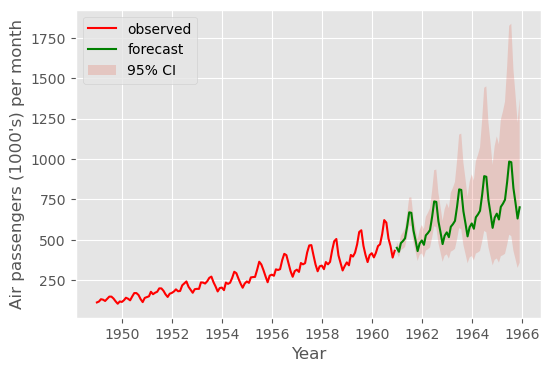

In [36]:
# Create a SARIMA model
model = SARIMAX(df_log, order=(0,1,1), seasonal_order=(0,1,1,12))

# Fit the model
results = model.fit()

# Make forecast of next 60 values
forecast = results.get_forecast(steps=60)

# Forecast mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of forecasts
conf_int = forecast.conf_int()

# Inverse log results
mean_forecast = np.exp(mean_forecast)
conf_int = np.exp(conf_int)

# Extract the forecast dates
dates = mean_forecast.index

plt.figure(figsize=(6,4))

# Plot air passenger numbers
plt.plot(df.index, df['air_passengers'], color='r', label='observed')

# Plot prediction means as line
plt.plot(dates, mean_forecast, color='g', label='forecast')

# Shade uncertainty area
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], label='95% CI', alpha=0.2)

# Set labels, etc.
plt.xlabel('Year')
plt.ylabel("Air passengers (1000's) per month")
plt.legend(loc='upper left');

In [37]:
# Print forecast
print(mean_forecast[:3],'\n')

# Print last predicted mean
print(mean_forecast.iloc[-1],'\n')

# Print last confidence interval
print(conf_int.iloc[-1],'\n')

1961-01-01    450.422050
1961-02-01    425.717973
1961-03-01    479.010573
Freq: MS, Name: predicted_mean, dtype: float64 

701.3655340598355 

lower air_passengers     358.035563
upper air_passengers    1373.923887
Name: 1965-12-01 00:00:00, dtype: float64 



---

## 5. Holt-Winters forecasting

### 5.1. Fitting data with Holt-Winters Exponential Smoothing (HWES)

**Fit data on single, double, and triple exponential smoothing**

In [38]:
# Define weight coefficient Alpha and Time Period S
S = 12
alpha = 1/(2*S)

# Fit data on single HWES
# Note! Single HWES doesn’t work for data with trends and seasonality
HWES1 = SimpleExpSmoothing(df).fit(smoothing_level = alpha, optimized = False, use_brute = True).fittedvalues

# Fit data on double HWES using a multiplicative trend
HWES2 = ExponentialSmoothing(df, trend = 'mul').fit().fittedvalues

# Fit data on triple HWES adding a multiplicative seasonality
HWES3 = ExponentialSmoothing(df, trend = 'mul', seasonal = 'mul', seasonal_periods = S).fit().fittedvalues

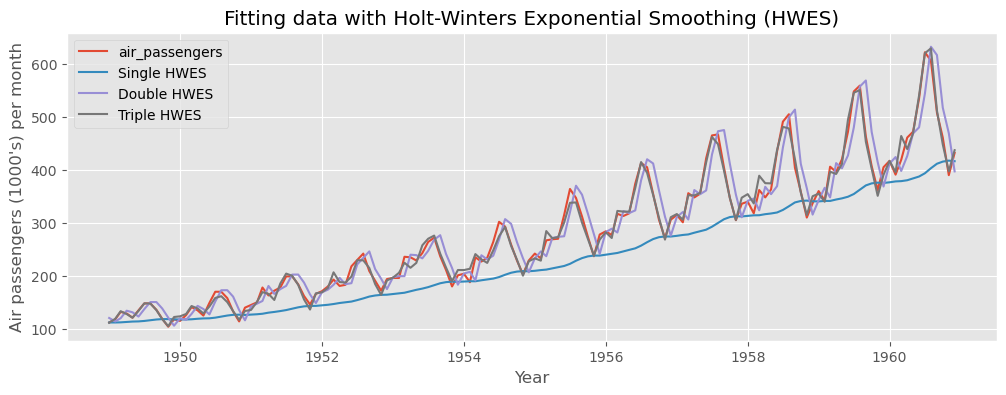

In [39]:
# Plot fitted data
plt.figure(figsize=(12,4))
plt.plot(df, label = 'air_passengers')
plt.plot(HWES1, label='Single HWES')
plt.plot(HWES2, label='Double HWES')
plt.plot(HWES3, label='Triple HWES')

# Set labels, etc.
plt.xlabel('Year')
plt.ylabel("Air passengers (1000's) per month")
plt.title('Fitting data with Holt-Winters Exponential Smoothing (HWES)')
plt.legend(loc='upper left');

### 5.2. Forecasting with Holt-Winters Exponential Smoothing (Triple HWES)

**Forecasting air passenger figures for 60 months post training set**

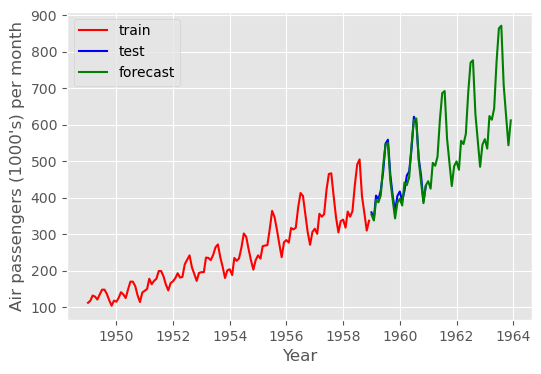

In [40]:
# Split data into train (~80%) and test (~20%) set
df_train = df.loc[:'1958']
df_test = df.loc['1959':]

# Create a HWES model
model = ExponentialSmoothing(df_train, trend = 'mul', seasonal = 'mul', seasonal_periods = S)

# Fit the model
results = model.fit()

# Make forecast of next 60 values
forecast = results.forecast(steps=60)

# Extract the forecast dates
dates = forecast.index

plt.figure(figsize=(6,4))

# Plot air passenger numbers
plt.plot(df_train.index, df.loc[:'1958'], color='r', label='train')
plt.plot(df_test.index, df.loc['1959':], color='b', label='test')

# Plot forecast as line
plt.plot(dates, forecast, color='g', label='forecast')

# Set labels, etc.
plt.xlabel('Year')
plt.ylabel("Air passengers (1000's) per month")
plt.legend(loc='upper left');

**Forecast air passenger figures for the next 5 years (post data set)**

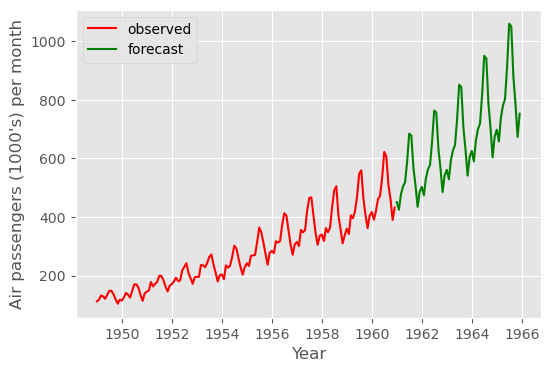

In [41]:
# Create a HWES model
model = ExponentialSmoothing(df, trend = 'mul', seasonal = 'mul', seasonal_periods = S)

# Fit the model
results = model.fit()

# Make forecast of next 60 values
forecast = results.forecast(steps=60)

# Extract the forecast dates
dates = forecast.index

plt.figure(figsize=(6,4))

# Plot air passenger numbers
plt.plot(df.index, df['air_passengers'], color='r', label='observed')

# Plot forecast as line
plt.plot(dates, forecast, color='g', label='forecast')

# Set labels, etc.
plt.xlabel('Year')
plt.ylabel("Air passengers (1000's) per month")
plt.legend(loc='upper left');

## 6. Facebook Prophet forecasting

### 6.1. Loading data

In [42]:
# Load data
ap = pd.read_csv('AirPassengers.csv')

In [43]:
# Rename column names
ap.columns = ['ds','y']

In [44]:
# Convert column dtype
ap['ds'] = pd.to_datetime(ap['ds'])

In [45]:
ap.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [46]:
ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      144 non-null    datetime64[ns]
 1   y       144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


### 6.2. Fb Prophet model

In [91]:
# Create a Prophet model
pm = Prophet(seasonality_mode = 'multiplicative')

# Fit the model
pm.fit(ap);

17:30:36 - cmdstanpy - INFO - Chain [1] start processing
17:30:36 - cmdstanpy - INFO - Chain [1] done processing


### 6.3. Forecasting

In [48]:
# Create dates for which predictions are to be made
future = pm.make_future_dataframe(periods = 60, freq = 'MS') #number of periods to forecast w/ month start freq
future.tail()

,ds
199,1965-08-01
200,1965-09-01
201,1965-10-01
202,1965-11-01
203,1965-12-01


The predict method will assign each row in `future` a **predicted value** which it names `yhat`. If you pass in historical dates, it will provide an **in-sample fit**. The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

In [49]:
# Make forecast
forecast = pm.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
199,1965-08-01,860.011757,829.548464,891.651860
200,1965-09-01,730.711278,703.178540,759.202373
201,1965-10-01,644.884439,620.245886,672.509227
202,1965-11-01,558.930845,535.789415,584.304819
203,1965-12-01,622.566120,597.191082,650.827802


### 6.4. Visualization

**Plot forecast**

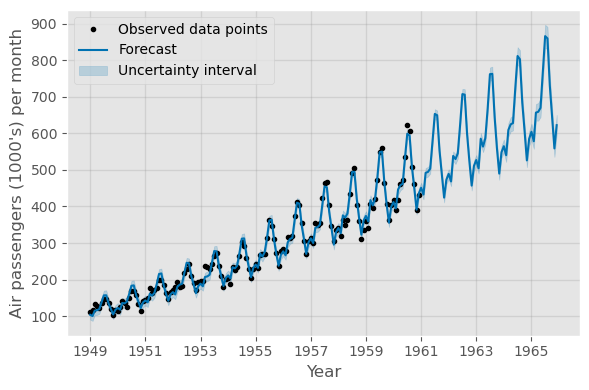

In [50]:
fig1 = pm.plot(forecast, figsize=(6,4), xlabel='Year', ylabel="Air passengers (1000's) per month", include_legend=True)

**Plot forecast components**

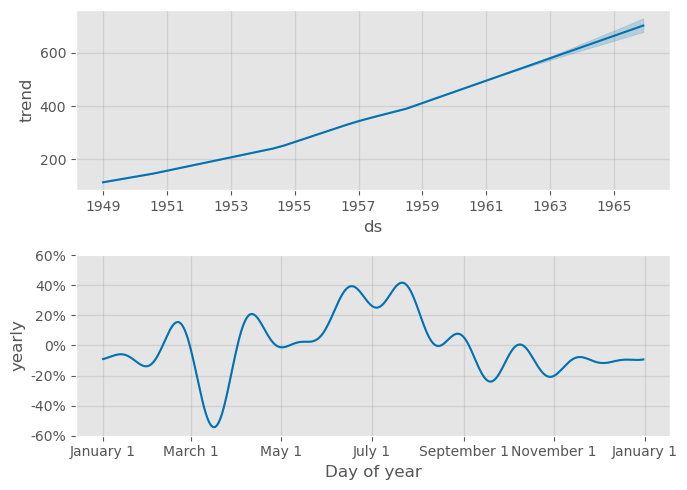

In [51]:
fig2 = pm.plot_components(forecast, figsize=(7,5)) #trend and yearly seasonality

## 7. Model comparison

**Plot SARIMA, Holt-Winters and Fb Prophet forecast side-by-side**

17:27:27 - cmdstanpy - INFO - Chain [1] start processing
17:27:27 - cmdstanpy - INFO - Chain [1] done processing


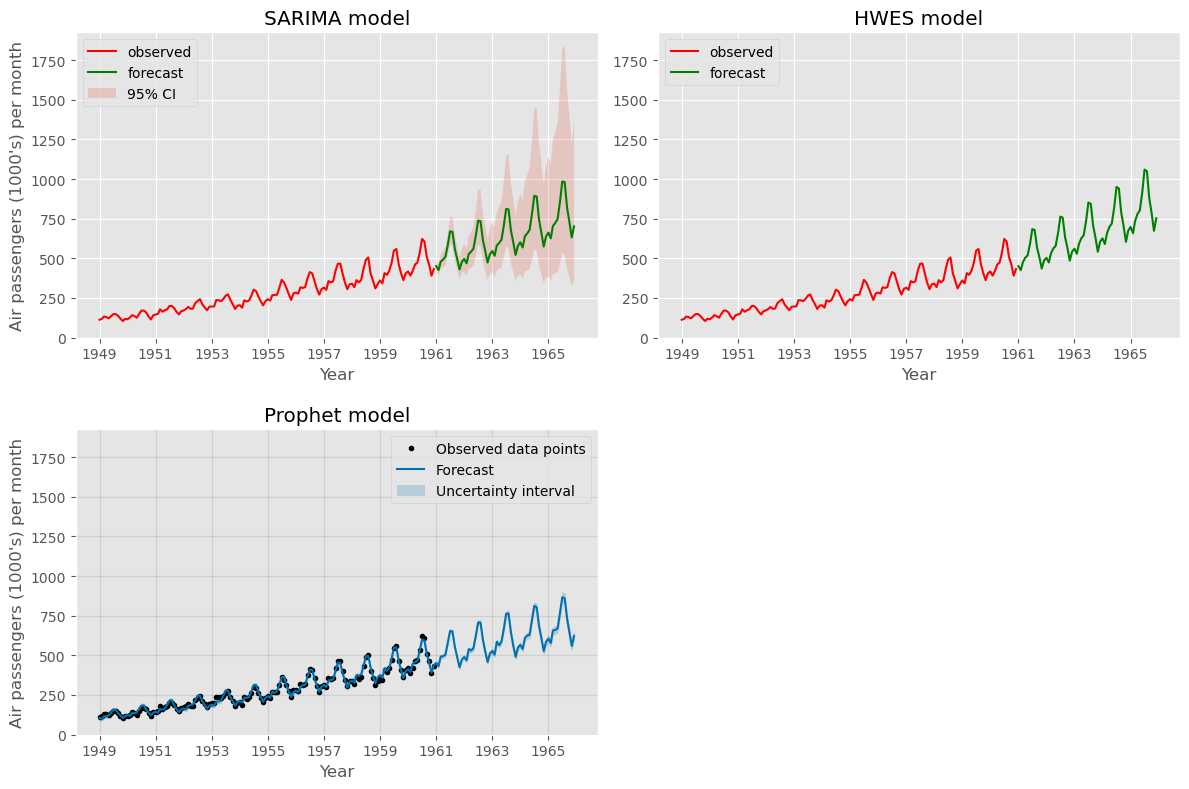

In [52]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
fig.tight_layout(pad=3)
ax[1,1].set_axis_off()

## SARIMA forecast
# Create a SARIMA model
model = SARIMAX(df_log, order=(0,1,1), seasonal_order=(0,1,1,12))
# Fit the model
results = model.fit()
# Make forecast of next 60 values
forecast = results.get_forecast(steps=60)
# Forecast mean
mean_forecast = forecast.predicted_mean
# Get confidence intervals of forecasts
conf_int = forecast.conf_int()
# Inverse log results
mean_forecast = np.exp(mean_forecast)
conf_int = np.exp(conf_int)
# Extract the forecast dates
dates = mean_forecast.index
# Plot air passenger numbers
ax[0,0].plot(df.index, df['air_passengers'], color='r', label='observed')
# Plot prediction means as line
ax[0,0].plot(dates, mean_forecast, color='g', label='forecast')
# Shade uncertainty area
ax[0,0].fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], label='95% CI', alpha=0.2)
# Set labels, etc.
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel("Air passengers (1000's) per month")
ax[0,0].xaxis.set_tick_params(labelleft=True)
ax[0,0].set_title('SARIMA model')
ax[0,0].legend(loc='upper left')

## Holt-Winters forecast
# Create a HWES model
model = ExponentialSmoothing(df, trend = 'mul', seasonal = 'mul', seasonal_periods = S) #S: 12
# Fit the model
results = model.fit()
# Make forecast of next 60 values
forecast = results.forecast(steps=60)
# Extract the forecast dates
dates = forecast.index
# Plot air passenger numbers
ax[0,1].plot(df.index, df['air_passengers'], color='r', label='observed')
# Plot forecast as line
ax[0,1].plot(dates, forecast, color='g', label='forecast')
# Set labels, etc.
ax[0,1].set_xlabel('Year')
ax[0,1].yaxis.set_tick_params(labelleft=True)
ax[0,1].xaxis.set_tick_params(labelleft=True)
ax[0,1].set_title('HWES model')
ax[0,1].legend(loc='upper left')
plt.subplots_adjust(wspace=0.2)

## Fb Prophet forecast
# Create a Prophet model
pm = Prophet(seasonality_mode = 'multiplicative')
# Fit the model
pm.fit(ap)
# Create dates for which predictions are to be made
future = pm.make_future_dataframe(periods = 60, freq = 'MS') #number of periods to forecast w/ month start freq
# Make forecast
forecast = pm.predict(future)
# Plot Fb Prophet forecast
pm.plot(forecast, xlabel='Year', ylabel="Air passengers (1000's) per month", include_legend=True, ax=ax[1,0])
ax[1,0].set_title('Prophet model')
plt.subplots_adjust(hspace=0.3);

---

## 8. Hypothesis testing

### 8.1. Define hypothesis

Null hypothesis (H$_0$): In the 1950's, monthly air passenger figures did not change from the first to the second half of the decade

Alternative hypothesis (H$_A$): In the 1950's, monthly air passenger figures did change from the first to the second half of the decade

### 8.2. Data for hypothesis testing

Create two sets of data 
- Monthly air passenger figures from start of 1950 to end of 1954
- Monthly air passenger figures from start of 1955 to end of 1959

Take sample of 50 monthly figures in each dataset.

In [53]:
# Subset air passenger figures according to date
N = 50
first = df.loc['1950':'1954'].sample(N, random_state=42)
second = df.loc['1955':'1959'].sample(N, random_state=42)

In [54]:
first.head(3)

,air_passengers
date,
1950-01-01,115
1950-06-01,149
1953-01-01,196


In [55]:
second.head(3)

,air_passengers
date,
1955-01-01,242
1955-06-01,315
1958-01-01,340


#### 8.2.1. Data distribution

Check if data is normally distributed

In [56]:
# Compute descriptive statistics
print('\033[1m1950-1954:\033[0m', stats.describe(first))
print('\033[1m1955-1959:\033[0m', stats.describe(second))

1950-1954: DescribeResult(nobs=50, minmax=(array([114], dtype=int64), array([302], dtype=int64)), mean=array([192.66]), variance=array([2071.73918367]), skewness=array([0.33352597]), kurtosis=array([-0.42179706]))
1955-1959: DescribeResult(nobs=50, minmax=(array([233], dtype=int64), array([559], dtype=int64)), mean=array([355.36]), variance=array([5923.78612245]), skewness=array([0.7416299]), kurtosis=array([0.12863719]))


**Documentation:**
* The skewness for a normal distribution is zero. Descriptive statistics for the 'First half decade' data implies an approximately symmetrical distribution, while statistics for the 'Second half decade' data indicate the distribution has a moderate positive skew
* A standard normal distribution has an excess kurtosis of zero. Both datasets have a kurtosis close to zero 

##### 8.2.1.1. Histogram

In [57]:
def plot_histogram(data1, data2, label1, label2, xlabel):
    """Function to plot data distribution as histogram"""
    plt.figure(figsize=(6,4))
    bins = int(np.sqrt(len(data1)))

    plt.hist(data1, bins=bins, label=label1, alpha=0.5)
    plt.hist(data2, bins=bins, label=label2, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.legend();    

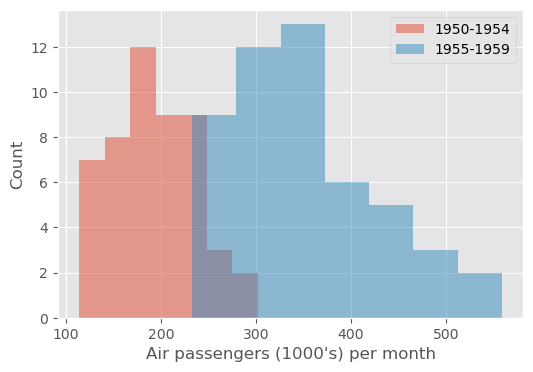

In [58]:
plot_histogram(data1 = first, data2 = second, label1 = '1950-1954', label2 = '1955-1959', xlabel = "Air passengers (1000's) per month")

**Documentation:**
* Data for the first half of the decade seems to be normally distributed, while data for the second half of the decade shows a tail to the right (positive skew)
* Histograms suffer from binning bias, check out other methods

##### 8.2.1.2. Empirical cumulative distribution function (ECDF)

Compare the ECDF of the data to the theoretical CDF of the Normal distribution

In [59]:
# Function to compute CDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [60]:
# Define data in dict to be checked for normal distribution 
data = {'1950-1954': first,
        '1955-1959': second}

In [61]:
data['1950-1954'][:3]

,air_passengers
date,
1950-01-01,115
1950-06-01,149
1953-01-01,196


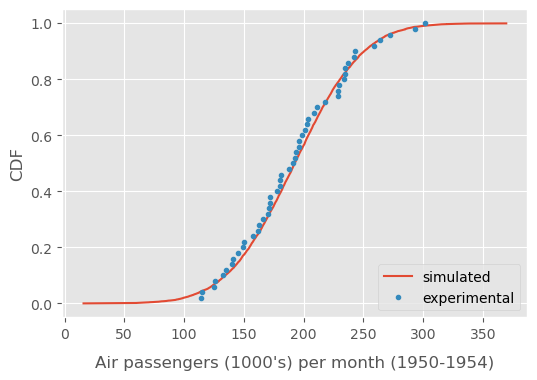

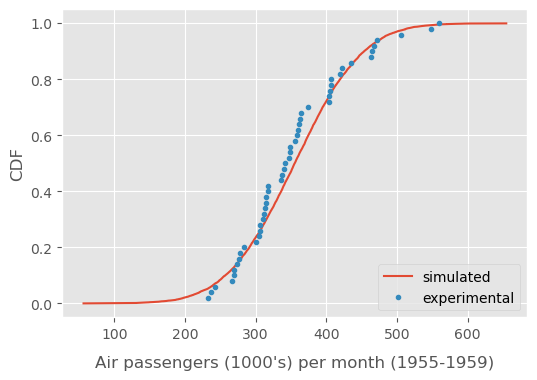

In [62]:
# Compute and plot CDF of experimental and simulated data (into separate figures)

for key, value in data.items():
    
    # Access respective dict data
    col = data[key].iloc[:,0]
    
    # Compute ECDF of experimental data
    x, y = ecdf(col)

    # Compute CDF of simulated data
    np.random.seed(42)
    mean = np.mean(col)
    std = np.std(col)
    samples = np.random.normal(mean, std, size=10000)
    x_theor, y_theor = ecdf(samples)
    
    # Plot ECDF and theoretical CDF
    plt.figure(figsize=(6,4))
    plt.plot(x_theor, y_theor)
    plt.plot(x, y, marker = '.', linestyle = 'none')
    plt.xlabel(f"Air passengers (1000's) per month ({key})", labelpad=10)
    plt.ylabel('CDF')
    plt.legend(('simulated', 'experimental'), loc = 'lower right');

**Documentation:**
* With the absence of binning bias, it is much clearer that the air passenger data for the first half of the decade is approx. normally distributed, while the data for the second half of the decade is not normally distributed

##### 8.2.1.3. Shapiro-Wilk Test

The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution

In [63]:
# Confidence level
alpha = 0.05

In [64]:
def test_normality(data, alpha=0.05):
    """
    Function performing Shapiro_Wilk Test and returning 
    a significance message on data normality
    
    Inputs:
    Array of sample data, alpha: confidence level    
    """
    
    # Null Hypothesis Dictionary
    null_hypothesis = {'H0': "Data is normally distributed.",
                       'H1': "Data does not come from a normal distribution."}
    
    statistic, p_value = stats.shapiro(data)
    print("test_statistic =", np.round(statistic, 3))
    print("p_value =", np.round(p_value, 3))
    
    if p_value < alpha:
        print('We reject the null hypothesis.')
        print(null_hypothesis['H1'])
    else:
        print('We accept the null hypothesis.') 
        print(null_hypothesis['H0'])

In [65]:
# Test data for normality
test_normality(first)

test_statistic = 0.979
p_value = 0.524
We accept the null hypothesis.
Data is normally distributed.


In [66]:
# Test data for normality (here: loop over data in dict)
for key, value in data.items():
    
    # Access respective dict data
    col = data[key]
    
    # Perform test and print result
    print(f'Dataset \033[1m{key}:\033[0m')
    test_normality(col)
    print(f'\n')   

Dataset 1950-1954:
test_statistic = 0.979
p_value = 0.524
We accept the null hypothesis.
Data is normally distributed.


Dataset 1955-1959:
test_statistic = 0.949
p_value = 0.031
We reject the null hypothesis.
Data does not come from a normal distribution.




**Documentation:**
* Confirming the ECDF plotting that the air passenger data for the first half of the decade is normally distributed, while the data for the second half of the decade is not normally distributed

### 8.3. Data normalization

#### 8.3.1. Z-score standardization

Normalize data by centering and scaling observations

In [67]:
def zscore(data):
    """
    Function to center and scale data
    Input: Array of sample data    
    """
    zscore = (data - np.mean(data, axis=0)) / np.std(data)
    return zscore

In [68]:
# Normalize data using z-score
first_zscore = zscore(first)
second_zscore = zscore(second)

In [69]:
first_zscore.head(3)

,air_passengers
date,
1950-01-01,-1.723522
1950-06-01,-0.968954
1953-01-01,0.074125


In [70]:
# Alternatively, loop over a list of dataframes to normalize data

# List of dataframes to be normalized
df_list = [first, second]

# Empty list to store normalized data
df_list_zscore = [] 

# Loop to normalize data
for df in df_list:
    zs = zscore(df)
    df_list_zscore.append(zs)

In [71]:
df_list_zscore[0][:3]

,air_passengers
date,
1950-01-01,-1.723522
1950-06-01,-0.968954
1953-01-01,0.074125


In [72]:
# Perform Shapiro-Wilk Test to check if data is normally distributed 
# (here: loop over data in list)
for df in df_list_zscore:
        
    # Perform test and print result
    test_normality(df)
    print(f'\n')

test_statistic = 0.979
p_value = 0.524
We accept the null hypothesis.
Data is normally distributed.


test_statistic = 0.949
p_value = 0.031
We reject the null hypothesis.
Data does not come from a normal distribution.




In [73]:
# Alternatively, loop over data in dict to normalize data

# Data in dict to be normalized
data = {'1950-1954': first,
        '1955-1959': second}

# Empty dict to store normalized data
data_zscore = {'1950-1954': [],
               '1955-1959': []}
    
# Loop to normalize data
for key, value in data.items():
    
    # Access respective dict data
    col = data[key]
    zs = zscore(col)
    data_zscore[key].append(zs)

In [74]:
data_zscore['1950-1954'][0][:3]

,air_passengers
date,
1950-01-01,-1.723522
1950-06-01,-0.968954
1953-01-01,0.074125


In [75]:
# Perform Shapiro-Wilk Test to check if data is normally distributed 
# (here: loop over data in dict)
for key, value in data_zscore.items():
    
    # Access respective dict data
    col = data_zscore[key]
    
    # Perform test and print result
    print(f'Dataset \033[1m{key}:\033[0m')
    test_normality(col)
    print(f'\n')  

Dataset 1950-1954:
test_statistic = 0.979
p_value = 0.524
We accept the null hypothesis.
Data is normally distributed.


Dataset 1955-1959:
test_statistic = 0.949
p_value = 0.031
We reject the null hypothesis.
Data does not come from a normal distribution.




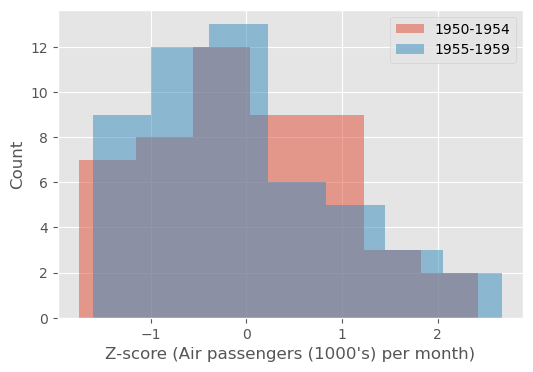

In [76]:
# Plot histogram for normalized data
plot_histogram(data1 = data_zscore['1950-1954'][0], data2 = data_zscore['1955-1959'][0], label1 = '1950-1954', label2 = '1955-1959', xlabel = "Z-score (Air passengers (1000's) per month)")

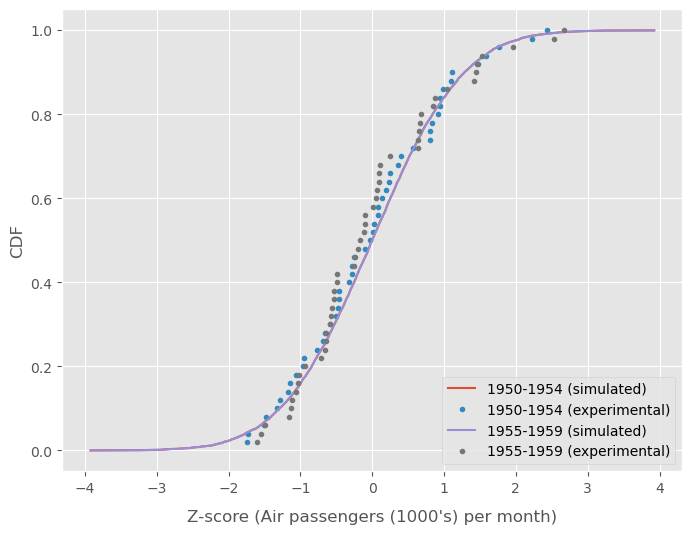

In [77]:
# Normalized data: Compute and plot CDF of experimental and simulated data

plt.figure(figsize=(8,6))

for key, value in data_zscore.items():
    
    # Access respective dict data
    col = data_zscore[key][0].iloc[:,0]
    
    # Compute ECDF of experimental data
    x, y = ecdf(col)

    # Compute CDF of simulated data
    np.random.seed(42)
    mean = np.mean(col)
    std = np.std(col)
    samples = np.random.normal(mean, std, size=10000)
    x_theor, y_theor = ecdf(samples)

    # Plot ECDF and theoretical CDF
    plt.plot(x_theor, y_theor, label=f'{key} (simulated)')
    plt.plot(x, y, marker = '.', linestyle = 'none', label=f'{key} (experimental)')
    plt.xlabel("Z-score (Air passengers (1000's) per month)", labelpad=10)
    plt.ylabel('CDF')
    plt.legend(loc = 'lower right');

**Documentation:**
* Z-score standardization was not sufficient to transform data into a normal distribution

#### 8.3.2. Log transformation

In [78]:
# Normalize data using log transformation (prior offset transformation not required due to absence of zeros)
first_log = np.log(first)
second_log = np.log(second)

In [79]:
first_log[:3]

,air_passengers
date,
1950-01-01,4.744932
1950-06-01,5.003946
1953-01-01,5.278115


In [80]:
# Alternatively, loop over data in dict to normalize data

# Data in dict to be normalized
data = {'1950-1954': first,
        '1955-1959': second}

# Empty dict to store normalized data
data_log = {'1950-1954': [],
            '1955-1959': []}
    
# Loop to normalize data
for key, value in data.items():
    
    # Access respective dict data
    col = data[key]
    log = np.log(col)
    data_log[key].append(log)

In [81]:
data_log['1950-1954'][0][:3]

,air_passengers
date,
1950-01-01,4.744932
1950-06-01,5.003946
1953-01-01,5.278115


In [82]:
# Perform Shapiro-Wilk Test to check if data is normally distributed 
# (here: loop over data in dict)
for key, value in data_log.items():
    
    # Access respective dict data
    col = data_log[key]
    
    # Perform test and print result
    print(f'Dataset \033[1m{key}:\033[0m')
    test_normality(col)
    print(f'\n')  

Dataset 1950-1954:
test_statistic = 0.984
p_value = 0.745
We accept the null hypothesis.
Data is normally distributed.


Dataset 1955-1959:
test_statistic = 0.98
p_value = 0.554
We accept the null hypothesis.
Data is normally distributed.




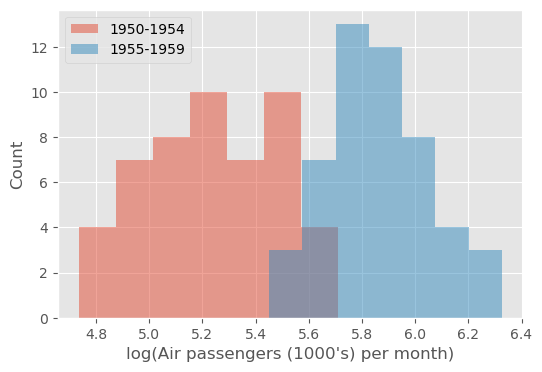

In [83]:
# Plot histogram for normalized data
plot_histogram(data1 = data_log['1950-1954'][0], data2 = data_log['1955-1959'][0], label1 = '1950-1954', label2 = '1955-1959', xlabel = "log(Air passengers (1000's) per month)")

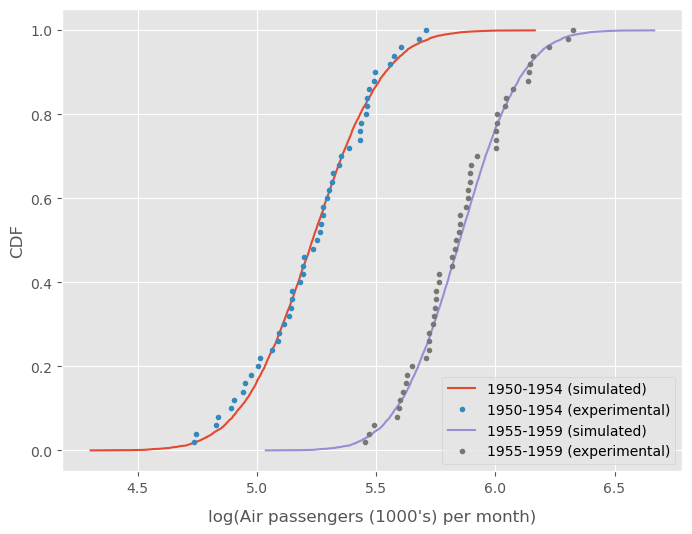

In [84]:
# Normalized data: Compute and plot CDF of experimental and simulated data

plt.figure(figsize=(8,6))

for key, value in data_log.items():
    
    # Access respective dict data
    col = data_log[key][0].iloc[:,0]
    
    # Compute ECDF of experimental data
    x, y = ecdf(col)

    # Compute CDF of simulated data
    np.random.seed(42)
    mean = np.mean(col)
    std = np.std(col)
    samples = np.random.normal(mean, std, size=10000)
    x_theor, y_theor = ecdf(samples)

    # Plot ECDF and theoretical CDF
    plt.plot(x_theor, y_theor, label=f'{key} (simulated)')
    plt.plot(x, y, marker = '.', linestyle = 'none', label=f'{key} (experimental)')
    plt.xlabel("log(Air passengers (1000's) per month)", labelpad=10)
    plt.ylabel('CDF')
    plt.legend(loc = 'lower right');

**Documentation:**
* Log transformation was sufficient to transform data into an approx. normal distribution

### 8.4. Student's *t*-test (two-tailed)

In [85]:
# Confidence level
alpha = 0.05

In [86]:
def ttest(data1, data2, alpha=0.05):
    """
    Function performing Student's t-test (two-tailed) and returning 
    a significance message
    
    Inputs:
    Two arrays of sample data, alpha: confidence level    
    """
    
    # Null Hypothesis Dictionary
    null_hypothesis = {'H0': "In the 1950's, monthly air passenger figures did not change from the first to the second half of the decade.",
                       'H1': "In the 1950's, monthly air passenger figures did change from the first to the second half of the decade."}
    
    t_statistic, p_value = stats.ttest_ind(data1, data2)
    print("t_statistic =", t_statistic)
    print("p_value =", p_value)
    
    if p_value < alpha:
        print('We reject the null hypothesis.')
        print(null_hypothesis['H1'])
    else:
        print('We accept the null hypothesis.') 
        print(null_hypothesis['H0'])

In [87]:
ttest(first_log, second_log)

t_statistic = [-13.71717466]
p_value = [1.54953195e-24]
We reject the null hypothesis.
In the 1950's, monthly air passenger figures did change from the first to the second half of the decade.


### 8.5. Mann-Whitney U-test

The Mann-Whitney U-test is a non-parametric alternative to an independent samples t-test

In [88]:
# Confidence level
alpha = 0.05

In [89]:
def mannwhitneyu(data1, data2, alpha=0.05):
    """
    Function performing Mann-Whitney U-test for non-parametric data
    and returning a significance message
    
    Inputs:
    Two arrays of sample data, alpha: confidence level    
    """
    
    # Null Hypothesis Dictionary
    null_hypothesis = {'H0': "In the 1950's, monthly air passenger figures did not change from the first to the second half of the decade.",
                       'H1': "In the 1950's, monthly air passenger figures did change from the first to the second half of the decade."}
    
    U_statistic, p_value = stats.mannwhitneyu(data1, data2)
    print("U_statistic =", U_statistic)
    print("p_value =", p_value)
    
    if p_value < alpha:
        print('We reject the null hypothesis.')
        print(null_hypothesis['H1'])
    else:
        print('We accept the null hypothesis.') 
        print(null_hypothesis['H0'])

In [90]:
mannwhitneyu(first, second)

U_statistic = [43.]
p_value = [8.96918542e-17]
We reject the null hypothesis.
In the 1950's, monthly air passenger figures did change from the first to the second half of the decade.
